In [37]:
def vecvel(x,y,sampling_rate):
    """
    ----------------------------------------------------------------------
    vecvel(x,y,sampling_rate)
    ---------------------------------------------------------------------- 
    Goal of the function :
    Compute eye velocity
    ----------------------------------------------------------------------
    Input(s) :
    x: raw data, horizontal components of the time series
    y: raw data, vertical components of the time series
    samplign_rate: eye tracking sampling rate
    ----------------------------------------------------------------------
    Output(s) :
    vx: velocity, horizontal component
    vy: velocity, vertical component
    ----------------------------------------------------------------------
    Function created by Martin Rolfs
    adapted by Martin SZINTE (mail@martinszinte.net)
    ----------------------------------------------------------------------
    """
    import numpy as np

    n = x.size

    vx = np.zeros_like(x)
    vy = np.zeros_like(y)

    vx[2:n-3] = sampling_rate/6 * (x[4:-1] + x[3:-2] - x[1:-4] - x[0:-5])
    vx[1] = sampling_rate/2*(x[2] - x[0]);
    vx[n-2] = sampling_rate/2*(x[-1]-x[-3])

    vy[2:n-3] = sampling_rate/6 * (y[4:-1] + y[3:-2] - y[1:-4] - y[0:-5])
    vy[1] = sampling_rate/2*(y[2] - y[0]);
    vy[n-2] = sampling_rate/2*(y[-1]-y[-3])

    return vx,vy

def microsacc_merge(x,y,vx,vy,velocity_th,min_dur,merge_interval):
    """
    ----------------------------------------------------------------------
    microsacc_merge(x,y,vx,vy,velocity_th,min_duration,merge_interval)
    ---------------------------------------------------------------------- 
    Goal of the function :
    Detection of monocular candidates for microsaccades   
    ----------------------------------------------------------------------
    Input(s) :
    x: raw data, horizontal components of the time series
    y: raw data, vertical components of the time series
    vx: velocity horizontal components of the time series
    vy: velocity vertical components of the time series
    velocity_th: velocity threshold
    min_dur: saccade minimum duration
    merge_interval: merge interval for subsequent saccade candidates
    ----------------------------------------------------------------------
    Output(s):
    out_val(0:num,0)   onset of saccade
    out_val(0:num,1)   end of saccade
    out_val(1:num,2)   peak velocity of saccade (vpeak)
    out_val(1:num,3)   saccade vector horizontal component 
    out_val(1:num,4)   saccade vector vertical component
    out_val(1:num,5)   saccade horizontal amplitude whole sequence
    out_val(1:num,6)   saccade vertical amplitude whole sequence
    ----------------------------------------------------------------------
    Function created by Martin Rolfs
    adapted by Martin SZINTE (mail@martinszinte.net) 
    ----------------------------------------------------------------------
    """
    import numpy as np

    
    # compute threshold
    msdx = np.sqrt(np.median(vx**2) - (np.median(vx))**2)
    msdy = np.sqrt(np.median(vy**2) - (np.median(vy))**2)

    if np.isnan(msdx):
        msdx = np.sqrt(np.mean(vx**2) - (np.mean(vx))**2)
        if msdx < np.nextafter(0,1):
            os.error('msdx < realmin')

    if np.isnan(msdy):
        msdy = np.sqrt(np.mean(vy**2) - (np.mean(vy))**2 )
        if msdy < np.nextafter(0,1):
            os.error('msdy < realmin')

    radiusx = velocity_th*msdx;
    radiusy = velocity_th*msdy;

    # compute test criterion: ellipse equation
    test = (vx/radiusx)**2 + (vy/radiusy)**2;
    indx = np.where(test>1)[0];

    # determine saccades
    N, nsac, dur, a, k = indx.shape[0], 0, 0, 0, 0

    while k < N-1:
        if indx[k+1]-indx[k]==1:
            dur += 1
        else:
            if dur >= min_dur:
                nsac += 1
                b = k
                if nsac == 1:
                    sac = np.array([indx[a],indx[b]])
                else:
                    sac = np.vstack((sac, np.array([indx[a],indx[b]])))
            a = k+1
            dur = 1

        k += 1
    
    # check for minimum duration
    if dur >= min_dur:
        nsac += 1;
        b = k;
        if nsac == 1:
            sac = np.array([indx[a],indx[b]])
        else:
            sac = np.vstack((sac, np.array([indx[a],indx[b]])))

    # merge saccades
    if nsac > 0:
        msac = np.copy(sac)
        s    = 0
        sss  = True
        nsac = 1
        while s < nsac-1:
            if sss == False:
                nsac += 1
                msac[nsac,:] = sac[s,:]
            if sac[s+1,0]-sac[s,1] <= merge_interval:
                msac[1] = sac[s+1,1]
                sss = True
            else:
                sss = False
            s += 1
        if sss == False:
            nsac += 1
            msac[nsac,:] = sac[s,:]
    else:
        msac = []
        nsac = 0
    
    # compute peak velocity, horizonal and vertical components
    msac = np.matrix(msac)
    out_val = np.matrix(np.zeros((msac.shape[0],7)))
                
    for s in np.arange(0,msac.shape[0],1):

        # onset and offset
        out_val[s,0],a = msac[s,0], msac[s,0]
        out_val[s,1],b = msac[s,1], msac[s,1]

        # saccade peak velocity (vpeak)
        vpeak = np.max(np.sqrt(vx[a:b]**2 + vy[a:b]**2))
        out_val[s,2] = vpeak

        # saccade vector (dx,dy)
        dx = x[b]-x[a]
        dy = y[b]-y[a]
        out_val[s,3] = dx
        out_val[s,4] = dy

        # saccade amplitude (dX,dY)
        minx,  maxx = np.min(x[a:b]),np.max(x[a:b])
        minix, maxix = np.where(x == minx)[0][0], np.where(x == maxx)[0][0]
        miny,  maxy = np.min(y[a:b]),np.max(y[a:b])
        miniy, maxiy = np.where(y == miny)[0][0], np.where(y == maxy)[0][0]
        dX = np.sign(maxix-minix)*(maxx-minx);
        dY = np.sign(maxiy-miniy)*(maxy-miny);
        out_val[s,5] = dX
        out_val[s,6] = dY
        
        
    return out_val

def saccpar(sac):
    """
    ----------------------------------------------------------------------
    saccpar(sac)
    ---------------------------------------------------------------------- 
    Goal of the function :
    Arange data from microsaccade detection
    ----------------------------------------------------------------------
    Input(s) :
    sac: monocular microsaccades matrix (from microsacc_merge)
    ----------------------------------------------------------------------
    Output(s):
    out_val(0:num,0)   saccade onset
    out_val(0:num,1)   saccade offset
    out_val(1:num,2)   saccade duration
    out_val(1:num,3)   saccade velocity peak
    out_val(1:num,4)   saccade vector distance
    out_val(1:num,5)   saccade vector angle
    out_val(1:num,6)   saccade whole sequence amplitude
    out_val(1:num,7)   saccade whole sequence angle
    ----------------------------------------------------------------------
    Function created by Martin Rolfs
    adapted by Martin SZINTE (mail@martinszinte.net) 
    ----------------------------------------------------------------------
    """
    
    if sac.shape[0] > 0:
        # 0. Saccade onset
        sac_onset = np.array(sac[:,0])

        # 1. Saccade offset
        sac_offset = np.array(sac[:,1])

        # 2. Saccade duration
        sac_dur = np.array(sac[:,1] - sac[:,0])

        # 3. Saccade peak velocity
        sac_pvel = np.array(sac[:,2])

        # 4. Saccade vector distance and angle
        sac_dist = np.sqrt(np.array(sac[:,3])**2 + np.array(sac[:,4])**2)

        # 5. Saccade vector angle
        sac_angd = np.arctan2(np.array(sac[:,4]),np.array(sac[:,3]))

        # 6. Saccade whole sequence amplitude
        sac_ampl = np.sqrt(np.array(sac[:,5])**2 + np.array(sac[:,6])**2)

        # 7. Saccade whole sequence amplitude
        sac_anga = np.arctan2(np.array(sac[:,6]),np.array(sac[:,5]))

        # make matrix
        out_val = np.matrix(np.hstack((sac_onset,sac_offset,sac_dur,sac_pvel,sac_dist,sac_angd,sac_ampl,sac_anga)))
    else:
        out_val = np.matrix([]);

    return out_val

def draw_bg_trial():

    # Saccade analysis per run and sequence
    # Define figure
    title_font = {'loc':'left', 'fontsize':14, 'fontweight':'bold'}
    axis_label_font = {'fontsize':14}
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75
    line_width_corr = 1.5

    # Horizontal eye trace
    screen_val =  12.5
    ymin1,ymax1,y_tick_num1 = -screen_val,screen_val,11
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    xmin1,xmax1,x_tick_num1 = 0,1,5
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)

    # Vertical eye trace
    ymin2,ymax2,y_tick_num2 = -screen_val,screen_val,11
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    xmin2,xmax2,x_tick_num2 = 0,1,5
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

    try: os.makedirs('{file_dir}/add/figures/'.format(file_dir = file_dir))
    except: pass

    cmap = 'hsv'
    cmap_steps = 16
    col_offset = 0#1/14.0
    base = cortex.utils.get_cmap(cmap)
    val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
    colmap = colors.LinearSegmentedColormap.from_list('my_colmap',base(val), N = cmap_steps)

    pursuit_polar_ang = np.deg2rad(np.arange(0,360,22.5))
    pursuit_ang_norm  = (pursuit_polar_ang + np.pi) / (np.pi * 2.0)
    pursuit_ang_norm  = (np.fmod(pursuit_ang_norm + col_offset,1))*cmap_steps

    pursuit_col_mat = colmap(pursuit_ang_norm.astype(int))
    pursuit_col_mat[:,3]=0.2

    saccade_polar_ang = np.deg2rad(np.arange(0,360,22.5)+180)
    saccade_ang_norm  = (saccade_polar_ang + np.pi) / (np.pi * 2.0)
    saccade_ang_norm  = (np.fmod(saccade_ang_norm + col_offset,1))*cmap_steps

    saccade_col_mat = colmap(saccade_ang_norm.astype(int))
    saccade_col_mat[:,3] = 0.8


    polar_ang = np.deg2rad(np.arange(0,360,22.5))
    trials_seq = saccades_tr

    fig = plt.figure(figsize = (15, 7))
    gridspec.GridSpec(2,8)
    run_data_logic = eye_data_runs_no_blink[:,3] == run_plot

    # Horizontal eye trace
    ax1 = plt.subplot2grid((2,8),(0,0),rowspan= 1, colspan = 4)
    ax1.set_ylabel('Hor. coord. (dva)',axis_label_font,labelpad = 0)
    ax1.set_ylim(bottom = ymin1, top = ymax1)
    ax1.set_yticks(y_tick1)
    ax1.set_xlabel('Time (%)',axis_label_font,labelpad = 10)
    ax1.set_xlim(left = xmin1, right = xmax1)
    ax1.set_xticks(x_tick1)
    ax1.set_facecolor(bg_col)
    ax1.set_title('Saccades: Horizontal eye position',**title_font)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    for rad in rads:
        ax1.plot(x_tick1,x_tick1*0+rad, color = [1,1,1], linewidth = axis_width*2)
        ax1.plot(x_tick1,x_tick1*0-rad, color = [1,1,1], linewidth = axis_width*2)

    # Vertical eye trace
    ax2 = plt.subplot2grid((2,8),(1,0),rowspan= 1, colspan = 4)
    ax2.set_ylabel('Ver. coord. (dva)',axis_label_font, labelpad = 0)
    ax2.set_ylim(bottom = ymin2, top = ymax2)
    ax2.set_yticks(y_tick2)
    ax2.set_xlabel('Time (%)',axis_label_font, labelpad = 10)
    ax2.set_xlim(left = xmin2, right = xmax2)
    ax2.set_xticks(x_tick2)
    ax2.set_facecolor(bg_col)
    ax2.set_title('Saccades: Vertical eye position',**title_font)
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    for rad in rads:
        ax2.plot(x_tick2,x_tick2*0+rad, color = [1,1,1], linewidth = axis_width*2)
        ax2.plot(x_tick2,x_tick2*0-rad, color = [1,1,1], linewidth = axis_width*2)

    # Screen eye trace
    ax3 = plt.subplot2grid((2,8),(0,4),rowspan= 2, colspan = 4)
    ax3.set_xlabel('Horizontal coordinates (dva)', axis_label_font, labelpad = 10)
    ax3.set_ylabel('Vertical coordinates (dva)', axis_label_font, labelpad = 0)
    ax3.set_xlim(left = ymin1, right = ymax1)
    ax3.set_xticks(y_tick1)
    ax3.set_ylim(bottom = ymin2, top = ymax2)
    ax3.set_yticks(y_tick2)
    ax3.set_facecolor(bg_col)
    ax3.set_title('Screen view',**title_font)
    ax3.set_aspect('equal')

    theta = np.linspace(0, 2*np.pi, 100)
    for rad in rads:
        ax3.plot(rad*np.cos(theta), rad*np.sin(theta),color = [1,1,1],linewidth = axis_width*3)

    plt.subplots_adjust(wspace = 1.4,hspace = 0.4)

    # color legend
    cbar_axis = fig.add_axes([0.47, 0.77, 0.8, 0.1], projection='polar')
    norm = colors.Normalize(0, 2*np.pi)
    t = np.linspace(0,2*np.pi,200,endpoint=True)
    r = [0,1]
    rg, tg = np.meshgrid(r,t)
    im = cbar_axis.pcolormesh(t, r, tg.T,norm= norm, cmap = colmap)
    cbar_axis.set_yticklabels([])
    cbar_axis.set_xticklabels([])
    cbar_axis.set_theta_zero_location("W",offset = -360/cmap_steps/2)
    cbar_axis.spines['polar'].set_visible(False)
    return ax1, ax2, ax3


def isincircle(x,y,xc,yc,rad):
    """
    ----------------------------------------------------------------------
    isincircle(x,y,xc,yc,rad)
    ---------------------------------------------------------------------- 
    Goal of the function :
    Check if coordinate in circle
    ----------------------------------------------------------------------
    Input(s) :
    x: x coordinate
    y: y coordinate
    xc: x coordinate of circle
    yc: y coordinate of circle
    rad: radius of circle
    ----------------------------------------------------------------------
    Output(s):
    incircle: (True) = yes, (False) = no 
    ----------------------------------------------------------------------
    Function created by Martin Rolfs
    adapted by Martin SZINTE (mail@martinszinte.net) 
    ----------------------------------------------------------------------
    """

    if np.sqrt((x-xc)**2 + (y-yc)**2) < rad:
        incircle = True
    else:
        incircle = False

    return incircle

In [2]:
# To do
# -----
# 1. try to run from matlab
# 2. try in windows computer
# 3. end tramslate saccade model to python
# 4. define all saccade metrics
# 5. rotate all data per eccentricity to fit 2D non isometric gaussian on distibution of landing point

# 6. apply anemo model to smooth pursuit eye traces rotated to main axis

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import platform
import numpy as np
import ipdb
import json
import h5py
import scipy.io
import cortex
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
deb = ipdb.set_trace

# Get inputs
# ----------
subject = 'sub-01'
task = 'EyeMov'

# Define analysis parameters
# --------------------------
with open('../behavior_settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Platform settings 
# -----------------
if platform.system() == 'Darwin':
    main_dir = analysis_info['main_dir_mac']
    
elif platform.system() == 'Windows':
    main_dir = analysis_info['main_dir_pc']

# Define experiments details
# --------------------------
num_run = analysis_info['num_run']
seq_trs = analysis_info['seq_trs']
eye_mov_seq = analysis_info['eye_mov_seq']
rads = analysis_info['rads']
pursuits_tr = np.arange(0,seq_trs,2)
saccades_tr = np.arange(1,seq_trs,2)


# Load data
# ---------
file_dir = '{exp_dir}/data/{sub}'.format(exp_dir = main_dir, sub = subject)
h5_filename = "{file_dir}/add/{sub}_task-{task}_eyedata.h5".format(file_dir = file_dir, sub = subject, task = task)
h5_file = h5py.File(h5_filename,'r')
folder_alias = 'eye_traces'
eye_data_runs_no_blink = np.array(h5_file['{folder_alias}/eye_data_runs_no_blink'.format(folder_alias = folder_alias)])
eye_data_runs = np.array(h5_file['{folder_alias}/eye_data_runs'.format(folder_alias = folder_alias)])
time_start_seq = np.array(h5_file['{folder_alias}/time_start_seq'.format(folder_alias = folder_alias)])
time_end_seq = np.array(h5_file['{folder_alias}/time_end_seq'.format(folder_alias = folder_alias)])

time_start_trial = np.array(h5_file['{folder_alias}/time_start_trial'.format(folder_alias = folder_alias)])
time_end_trial = np.array(h5_file['{folder_alias}/time_end_trial'.format(folder_alias = folder_alias)])
amp_sequence = np.array(h5_file['{folder_alias}/amp_sequence'.format(folder_alias = folder_alias)])


In [3]:
# Saccade analysis per run and sequence
# Define figure
title_font = {'loc':'left', 'fontsize':14, 'fontweight':'bold'}
axis_label_font = {'fontsize':14}
bg_col = (0.9, 0.9, 0.9)
axis_width = 0.75
line_width_corr = 1.5

# Horizontal eye trace
screen_val =  12.5
ymin1,ymax1,y_tick_num1 = -screen_val,screen_val,11
y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
xmin1,xmax1,x_tick_num1 = 0,1,5
xmin2,xmax2,x_tick_num2 = 0,1,5
x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)
x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

# Vertical eye trace
ymin2,ymax2,y_tick_num2 = -screen_val,screen_val,11
xmin2,xmax2,x_tick_num2 = 0,1,num_run+1
y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

try: os.makedirs('{file_dir}/add/figures/'.format(file_dir = file_dir))
except: pass

cmap = 'hsv'
cmap_steps = 16
col_offset = 0#1/14.0
base = cortex.utils.get_cmap(cmap)
val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
colmap = colors.LinearSegmentedColormap.from_list('my_colmap',base(val), N = cmap_steps)

pursuit_polar_ang = np.deg2rad(np.arange(0,360,22.5))
pursuit_ang_norm  = (pursuit_polar_ang + np.pi) / (np.pi * 2.0)
pursuit_ang_norm  = (np.fmod(pursuit_ang_norm + col_offset,1))*cmap_steps

pursuit_col_mat = colmap(pursuit_ang_norm.astype(int))
pursuit_col_mat[:,3]=0.2

saccade_polar_ang = np.deg2rad(np.arange(0,360,22.5)+180)
saccade_ang_norm  = (saccade_polar_ang + np.pi) / (np.pi * 2.0)
saccade_ang_norm  = (np.fmod(saccade_ang_norm + col_offset,1))*cmap_steps

saccade_col_mat = colmap(saccade_ang_norm.astype(int))
saccade_col_mat[:,3] = 0.8


polar_ang = np.deg2rad(np.arange(0,360,22.5))
trials_seq = saccades_tr


NameError: name 'ff' is not defined

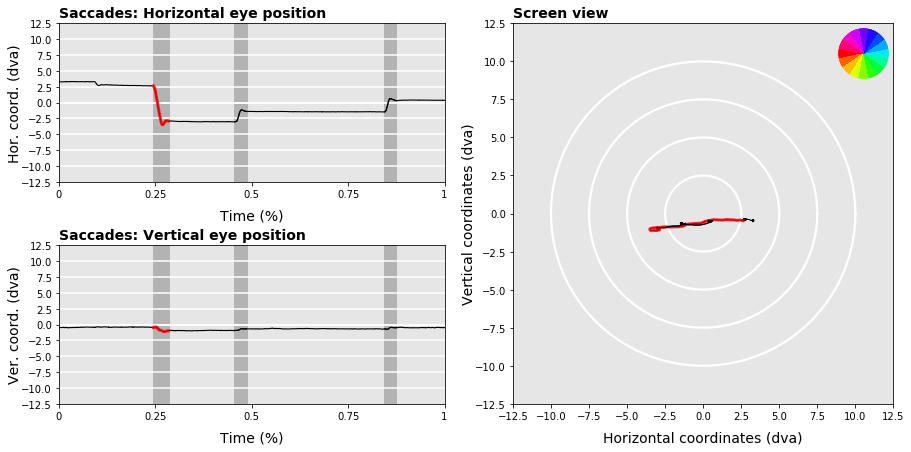

In [101]:
# get saccade metrics

for run_plot in np.arange(0,num_run,1):
    run_data_logic = eye_data_runs_no_blink[:,3] == run_plot
    
    for seq_plot in eye_mov_seq:
        seq_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_seq[seq_plot,run_plot],
                                        eye_data_runs_no_blink[:,0] <= time_end_seq[seq_plot,run_plot])
        

        for trial_num,trial_plot in enumerate(trials_seq):
            trial_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_trial[trial_plot,seq_plot,run_plot],
                                              eye_data_runs_no_blink[:,0] <= time_end_trial[trial_plot,seq_plot,run_plot])
            
            data_logic = np.logical_and.reduce(np.array((run_data_logic,seq_data_logic,trial_data_logic)))
            
            
            # fixation target position
            amp_sac = rads[int(amp_sequence[seq_plot])]
            fix_pos_x, fix_pos_y = np.round(np.cos(polar_ang[trial_num])*amp_sac,decimals=3),\
                                   np.round(np.sin(polar_ang[trial_num])*amp_sac,decimals=3)
            
            # saccade target position
            sac_pos_x,sac_pos_y = 0,0

            
            # trial start and end
            # define trial start and trial end
            t_trial_start = time_start_trial[trial_plot,seq_plot,run_plot]
            t_trial_end = time_end_trial[trial_plot,seq_plot,run_plot]
            dur_trial = t_trial_end - t_trial_start
            time_prct = ((eye_data_runs[data_logic][:,0]- t_trial_start)/dur_trial)

            
            # Indicators
            miss_time = 0        #1 missing data
            no_saccade = 0       #2 no saccade detected
            sac_accuracy = 0     #3 saccade accuracy (only fixation in right area)
            microsaccade = 0     #4 microsaccade
        
            # Saccade analysis parameters
            sampling_rate = 1000
            velocity_th = 1.5
            min_dur = 20
            merge_interval = 20
            sac_fix_rad = 2*(amp_sac/10)
            num_res = 22
            
            #1 Missing data point
            if np.sum(np.diff(eye_data_runs[trial_data_logic,0])>1000/sampling_rate) > 0:
                miss_time = 1

            
            # 3 saccade detection
            if not miss_time:
                t, p, x, y = eye_data_runs[trial_data_logic,0],time_prct,eye_data_runs[trial_data_logic,1],eye_data_runs[trial_data_logic,2]
                vx, vy = vecvel(x,y,sampling_rate)                
                sac = microsacc_merge(x,y,vx,vy,velocity_th,min_dur,merge_interval)                
                ms = saccpar(sac)
                
                if ms.shape[1] > 0:
                    n_sac_tot = ms.shape[0]     

                    s1 = 0
                    while s1 < n_sac_tot:
                        
                        sac_x_onset, sac_x_offset = x[int(ms[s1,0])], x[int(ms[s1,1])]
                        sac_y_onset, sac_y_offset = y[int(ms[s1,0])], y[int(ms[s1,1])]
                        sac_t_onset, sac_t_offset = t[int(ms[s1,0])], t[int(ms[s1,1])]
                        sac_p_onset, sac_p_offset = p[int(ms[s1,0])], p[int(ms[s1,1])]
                        sac_dur,     sac_vpeak    = ms[s1,2],         ms[s1,3]
                        sac_dist,    sac_amp      = ms[s1,4],         ms[s1,6]
                        sac_dist_ang,sac_amp_ang  = ms[s1,5],         ms[s1,7]
                                                
                        fix_cor = isincircle(sac_x_onset,sac_y_onset,fix_pos_x,fix_pos_y,sac_fix_rad)
                        sac_cor = 1 
#                         sac_cor = isincircle(sac_x_offset,sac_y_offset,sac_pos_x,sac_pos_y,sac_fix_rad)
                            
                        if np.logical_and(fix_cor,sac_cor):
                            sac_accuracy = 1;
                        else:
                            sac_accuracy = 0;
                            
                        if sac_amp <= 1.0:
                            microsaccade = 1
                        
                        if np.logical_and(trial_num==0,s1==0):
                            vals_all = np.array([   trial_num,    s1,           sac_x_onset,    sac_x_offset,   sac_y_onset,\
                                                    sac_y_offset, sac_t_onset,  sac_t_offset,   sac_p_onset,    sac_p_offset,\
                                                    sac_dur,      sac_vpeak,    sac_dist,       sac_amp,        sac_dist_ang,\
                                                    sac_amp_ang,  fix_cor,      sac_cor,        miss_time,      sac_accuracy,\
                                                    no_saccade,   microsaccade])
                        else:
                            vals_all = np.vstack((vals_all,np.array([   trial_num,    s1,           sac_x_onset,    sac_x_offset,   sac_y_onset,\
                                                                        sac_y_offset, sac_t_onset,  sac_t_offset,   sac_p_onset,    sac_p_offset,\
                                                                        sac_dur,      sac_vpeak,    sac_dist,       sac_amp,        sac_dist_ang,\
                                                                        sac_amp_ang,  fix_cor,      sac_cor,        miss_time,      sac_accuracy,\
                                                                        no_saccade,   microsaccade])))
                        s1 += 1
                else:
                    no_saccade = 1
                    s1 = 0
                    if np.logical_and(trial_num==0,s1==0):
                        vals_all = np.array([np.zeros(num_res)*np.nan])
                    else:
                        vals_all = np.vstack((vals_all,np.array([np.zeros(num_res)*np.nan])))
                
                
            
            ax1,ax2,ax3 = draw_bg_trial()
            
            
            vals_trial = vals_all[vals_all[:,0]==trial_num,:]
            
            # plot whole trial
            ax1.plot(time_prct,x,color = [0,0,0],linewidth = axis_width*1.5)
            ax2.plot(time_prct,y,color = [0,0,0],linewidth = axis_width*1.5)
            ax3.plot(x,y,color = [0,0,0],linewidth = axis_width*1.5)
            
            for trial_sac in vals_trial[:,1]:
                trial_sac_logic = vals_trial[:,1] == trial_sac
                vals_trial_sac = vals_trial[trial_sac_logic,:]

                sac_t_onset = vals_trial_sac[0,6]
                sac_t_offset = vals_trial_sac[0,7]
                sac_p_onset = vals_trial_sac[0,8]
                sac_p_offset = vals_trial_sac[0,9]
                sac_acc = vals_trial_sac[0,19]
                
                x_sac = x[np.logical_and(t > sac_t_onset,t < sac_t_offset)]
                y_sac = y[np.logical_and(t > sac_t_onset,t < sac_t_offset)]
                t_sac = t[np.logical_and(t > sac_t_onset,t < sac_t_offset)]
                p_sac = p[np.logical_and(t > sac_t_onset,t < sac_t_offset)]
            
                if sac_acc:
                    plot_color = saccade_col_mat[trial_num,:]
                    linewidth_sac = axis_width*4
                else:
                    plot_color = [0,0,0]
                    linewidth_sac = axis_width*1.5
            
                ax1.fill([sac_p_onset,sac_p_offset,sac_p_offset,sac_p_onset],[screen_val,screen_val,-screen_val,-screen_val],color = [0.7,0.7,0.7])
                ax1.plot(p_sac,x_sac,color = plot_color,linewidth = linewidth_sac)
                ax2.fill([sac_p_onset,sac_p_offset,sac_p_offset,sac_p_onset],[screen_val,screen_val,-screen_val,-screen_val],color = [0.7,0.7,0.7])
                ax2.plot(p_sac,y_sac,color = plot_color,linewidth = linewidth_sac)
                ax3.plot(x_sac,y_sac,color = plot_color,linewidth = linewidth_sac)

            ff
                
            

808862.0

In [83]:
vals_trial[vals_trial[:,1] == 0,6]

array([808862.])

In [84]:
vals_trial = vals_all[vals_all[:,0]==trial_num,:]

In [85]:
vals_trial.shape

(3, 22)